# COVID-19 time-series analysis

Jonathan Stickel, 2020

This purpose of this notebook (and repository) is to make available a set of time-series
analyses of COVID-19 data. Data sources are:

- https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE COVID-19 data)
- https://data.worldbank.org/indicator/sp.pop.totl (population data)

By default, the COVID-19 data is grabbed from the Johns Hopkins CSSE github.com repository. When using this notebook on a local machine, you may instead clone the repo to an adjent folder and keep it up-to-date (see arguments to `covid19_global` function).

Dependencies are:

- `numpy`
- `pandas`
- `matplotlib`
- `cvxopt
- `scikit.datasmooth` (can be pip installed)

Also, `covid19ts` is part of this repository.

Click on this link for a web-based "live" notebook (it may take awhile to load, be patient):
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jjstickel/covid-19_ts_analysis.git/master?filepath=analyze_covide_time_series_notebook.ipynb)


In [2]:
# import modules
import numpy as np
from decimal import Decimal
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib.dates as mdates
from covid19ts import covid19_global

# User input

Put up to 5 countries of interest in this list. Must be the same name used in the JH global files, and (at the moment), it must be a single entry in the file (e.g., China has multiple entries and will cause an Exception)

In [3]:
countries = ["US", "Italy", "Spain", "Germany", "Iran"]

Read in Johns Hopkins CSSE COVID-19 timeseries data for the locations specified and perform these operations:
- normalize cases to be per capita
- smooth the cases data
- set time-zero for each location and shift elapsed time in days
- determine rates (i.e., the derivative) for cases

In [4]:
corona = covid19_global(countries)

# extract common variables for ease-of-use
mult = corona["mult"]
critlow = corona["critlow"]
nctry = len(countries)
dates = corona["dates"]

Determine an exponential fit for the early part of the confirmed cases. As will be observed in the plots, it does not take very long before the growth of cases slows from exponential. Initial doubling time is printed out after the code block.

In [5]:
# compute exponential fit to confirmed cases
def expfit(t, y):
    """
    fit data to exponential function
    """
    k, lna = np.polyfit(t, np.log(y), 1)
    return np.exp(lna), k

crithigh = 200*1e-6 # upper bound for exponential fit, for fitting confirmed
for country in countries:
    ctryd = corona[country]
    criteval = ctryd['cnf_pc'] < crithigh*mult
    idx0 = ctryd['idx0']
    idx1 = np.nonzero(criteval)[0][-1]
    a, k = expfit(ctryd['days'][idx0:idx1], ctryd['cnf_pc'][idx0:idx1])
    dt2in = np.log(2)/k
    print("initial doubling time for %s was %g days" % (country, dt2in))
    ctryd['a'] = a
    ctryd['k'] = k
    ctryd['dt2in'] = dt2in
    ctryd['cnf_expfit'] = a*np.exp(k*ctryd['days'])

initial doubling time for US was 2.08913 days
initial doubling time for Italy was 2.96734 days
initial doubling time for Spain was 1.90011 days
initial doubling time for Germany was 2.67981 days
initial doubling time for Iran was 4.19274 days


*Calculate* "active" cases by $a = c - d -r$ ($a=$ active, $c=$ confirmed, $d=$ deaths, and $r=$ recovered). Also, *estimate* active cases by presuming all confirmed cases have recovered or died in an aeverage number of days. Estimate of recovery time from:
- https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
- https://towardsdatascience.com/visual-notes-from-singapores-first-100-fully-recovered-covid-19-patients-aad7f2e1d0a0

In [16]:
rectime = 14 # days, 1 day = 1 data point -- you can change this number to see the affect on estimated acive cases
for country in countries:
    ctryd = corona[country]
    # calculate active cased based on JH data
    ctryd["acv_pc"] = ctryd["cnf_pc"] - ctryd["dth_pc"] - ctryd["rec_pc"]
    # estimate active cases based on an "average" recovery time
    ctryd["acvest_pc"] = ctryd["cnf_pc"].copy()
    ctryd["acvest_pc"][rectime:] = ctryd["acvest_pc"][rectime:] - ctryd["cnf_pc"][:-rectime]
    # recovered estimate -- not sure of the value of this...
    ctryd["recest_pc"] = ctryd["cnf_pc"] - ctryd["dth_pc"] - ctryd["acv_pc"]

# Plotting

In [7]:
# plotting setup
rcParams.update({'font.size': 14})
fw = 8
fh = 6
clr = ['C%g' % i for i in range(10)]
sbl = ["o", "s", "v", "d", "x"]
savefigs = False

# get inverse human readable form for t=0 criterium
clinv_tup = Decimal("%.1g"%(1/critlow)).as_tuple()
clinv_dig = clinv_tup.digits[0]
clinv_exp = clinv_tup.exponent

N=0 # figure counter

# Total cases (confirmed and deaths), not scaled

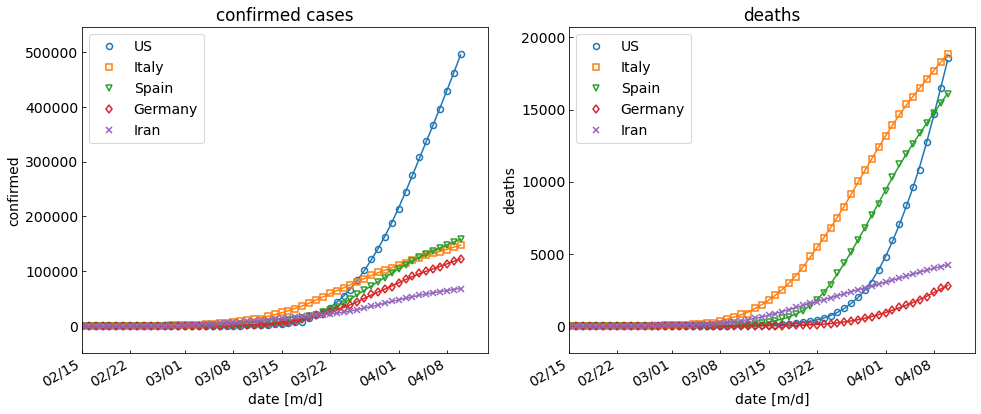

In [8]:
N+=1; figure(N, figsize=(2*fw,fh))
clf()
subplot(121)
for i in range(nctry):
    ctryd = corona[countries[i]]
    population = ctryd['population']
    plot(dates, ctryd['cnf'], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    #plot(dates, ctryd['cnf_expfit']*population/mult, '--'+clr[i], lw=1.5)
    plot(dates, ctryd['cnf_pc_h']*population/mult, '-'+clr[i])
ax = gca()
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%m/%d"))
setp(ax.get_xticklabels(), rotation=30, ha="right")
cnf_max = max([corona[country]['cnf'].max() for country in countries])
axis(xmin = datetime(year=2020, month=2, day = 15), ymin=0-cnf_max*0.1, ymax = cnf_max*1.1)
xlabel("date [m/d]")
ylabel("confirmed")
legend(loc='best')
title("confirmed cases")

subplot(122)
for i in range(nctry):
    ctryd = corona[countries[i]]
    population = ctryd['population']
    plot(dates, ctryd['dth'], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(dates, ctryd['dth_pc_h']*population/mult, '-'+clr[i])
ax = gca()
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%m/%d"))
setp(ax.get_xticklabels(), rotation=30, ha="right")
dth_max = max([corona[country]['dth'].max() for country in countries])
axis(xmin = datetime(year=2020, month=2, day = 15), ymin=0-dth_max*0.1, ymax = dth_max*1.1)
xlabel("date [m/d]")
ylabel("deaths")
legend(loc='best')
title("deaths");

Points are the data, lines are smoothing fit. 

# Per capita cases (confirmed and deaths) with elapsed number of days from a specified time zero as indicated in the x-axis

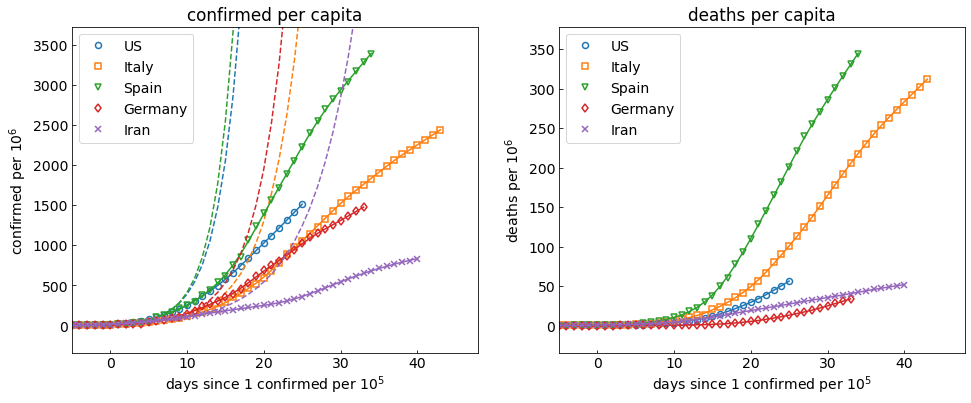

In [9]:
N+=1; figure(N, figsize=(2*fw,fh))
clf()
subplot(121)
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    plot(days, ctryd["cnf_pc"], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(days, ctryd["cnf_expfit"], '--'+clr[i], lw=1.5)
    plot(days, ctryd["cnf_pc_h"], '-'+clr[i])
scaled_max = max([corona[country]['cnf_pc'].max() for country in countries])
axis(xmin=-5, ymin=0-scaled_max*0.1, ymax=scaled_max*1.1)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("confirmed per $10^%i$" % np.log10(mult))
legend(loc='best')
title("confirmed per capita")

subplot(122)
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    plot(days, ctryd["dth_pc"], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(days, ctryd["dth_pc_h"], '-'+clr[i])
scaled_max = max([corona[country]['dth_pc'].max() for country in countries])
axis(xmin=-5, ymin=0-scaled_max*0.1, ymax=scaled_max*1.1)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("deaths per $10^%i$" % np.log10(mult))
legend(loc='best')
title("deaths per capita");

On a per capita basis, the US is actually fairing OK compared to some European countries (e.g., Spain and Italy). The dashed lines are exponential fits to the early-time confirmed cases. Despite all the talk about COVID-19 growing exponentially, exponential growth did not last very long at all. Now growth is linear or sublinear for many countries, as will be shown in the subsequent plots of *growth rates*.

# Per capita growth rates (confirmed and deaths)

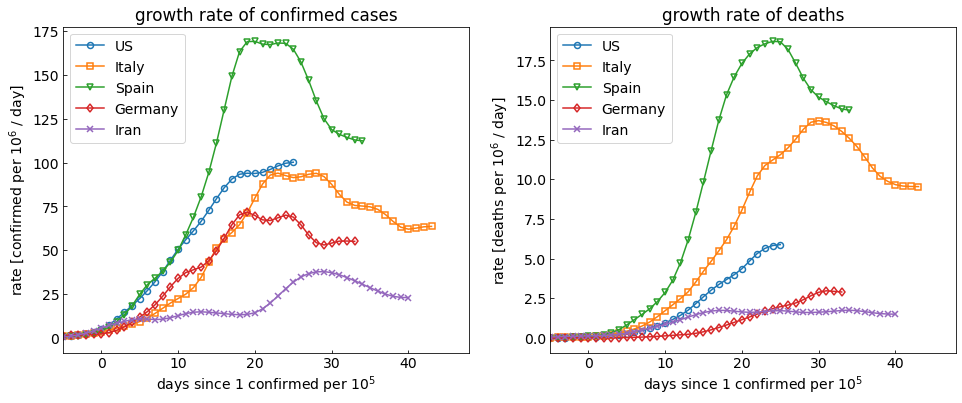

In [10]:
# rate confirmed per capita
N+=1; figure(N, figsize=(2*fw,fh))
clf()
subplot(121)
for i in range(nctry):
    ctryd = corona[countries[i]]
    plot(ctryd["days"], ctryd["cnf_rate"], "-"+sbl[i]+clr[i], mfc='none', mew=1.5,
         label=ctryd["name"])
axis(xmin = -5)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("rate [confirmed per $10^%i$ / day]" % np.log10(mult))
legend(loc="best")
title("growth rate of confirmed cases")

subplot(122)
for i in range(nctry):
    ctryd = corona[countries[i]]
    plot(ctryd["days"], ctryd["dth_rate"], "-"+sbl[i]+clr[i], mfc='none', mew=1.5,
         label=ctryd["name"])
axis(xmin = -5)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("rate [deaths per $10^%i$ / day]" % np.log10(mult))
legend(loc="best")
title("growth rate of deaths");

Growth rate is the derivative of the cases (i.e., instantaneous slope for each day). Rates for some countries have decreased from their peak but seem to have continued linear growth (i.e., a flat rate). 

# Active cases and case fatality ratio (CFR)

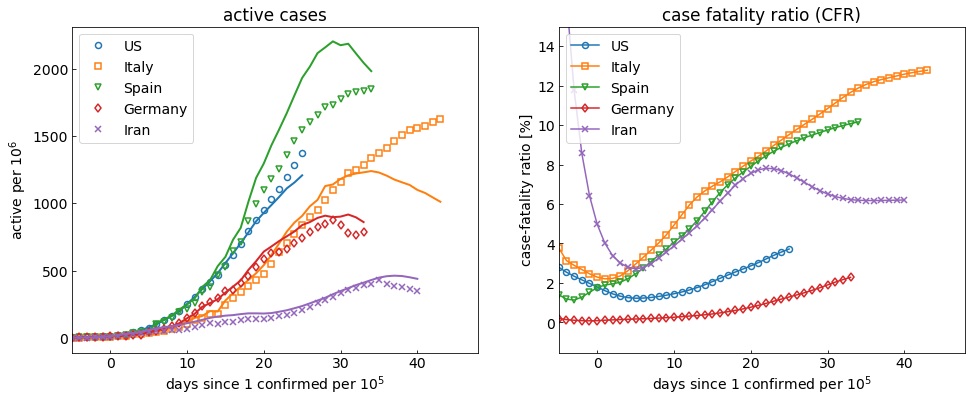

In [15]:
N+=1; figure(N, figsize=(2*fw,fh))
clf()
subplot(121)
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    plot(days, ctryd["acv_pc"], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(days, ctryd["acvest_pc"], "-"+clr[i], lw=2)
#scaled_max = max([corona[country]['cnf_pc'].max() for country in countries])
axis(xmin=-5)#, ymin=0-scaled_max*0.1, ymax=scaled_max*1.1)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("active per $10^%i$" % np.log10(mult))
legend(loc='best')
title("active cases")
subplot(122)
for i in range(nctry):
    ctryd = corona[countries[i]]
    plot(ctryd["days"], ctryd["dth_pc_h"]/ctryd["cnf_pc_h"]*100, "-"+sbl[i]+clr[i], mfc='none',
         mew=1.5, label=ctryd["name"])
axis(xmin = -5, ymax=15)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("case-fatality ratio [%]")
legend(loc="best")
title("case fatality ratio (CFR)");

Have we peaked? A curve of active cases would help us answer this. Active cases can be calculated easily from data from confirmed, deaths, and recovered. Unfortunately, data for recovered cases is still not very good ([see here](https://www.cnn.com/2020/04/04/health/recovery-coronavirus-tracking-data-explainer/index.html)). For that reason, I also estimate active cases by presuming that all confirmed cases are resolved (dead or recovered) in an average number of days (I estimated recovery time to be 14 days based on the links I provided above). The symbols are the calculated active cases and the lines are the estimated active cases. By the estimated numbers, some countries have peaked, but definitely not the US yet (as of 4/11/20).

The "case fatality ratio", or *CFR*, is an indication of how deadly a disease is. It is only an indication because it is limited by how many actual cases are measured and *confirmed*. Here, we see that the US is doing pretty good compared to other countries. There is a lot of talk about how we are not doing enough testing and that the confirmed numbers are low. Therefore, more testing would increase the denominator of the ratio and would make the CFR *even lower*. (Note: the CFR is commonly called the case fatality *rate*. The use of the word rate here is technically incorrect---rate refers to something changing over *time*. [More info here](https://ourworldindata.org/coronavirus?fbclid=IwAR3zOvtt7gqkhitoHJ_lXDr3eDeE_JPtfukpOkY94PSaBm_hmrMvWCXWFpg#what-do-we-know-about-the-risk-of-dying-from-covid-19))

# Some other plots

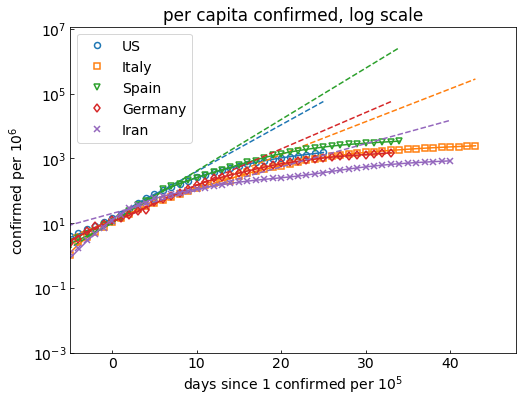

In [12]:
# log-scale confirmed per capita
N+=1; figure(N, figsize=(fw,fh))
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    semilogy(ctryd["days"], ctryd["cnf_pc"], sbl[i]+clr[i], mfc='none', mew=1.5,
             label=ctryd["name"])
    semilogy(ctryd["days"], ctryd["cnf_expfit"], '--'+clr[i], lw=1.5)
    semilogy(ctryd["days"], ctryd["cnf_pc_h"], '-'+clr[i])
axis(xmin=-5, ymin=1e-3)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("confirmed per $10^%i$" % np.log10(mult))
legend(loc='best')
title("per capita confirmed, log scale");

This plot shows confirmed cases (per capita) on a semilog scale. A number of plots shown on the web are on a log scale like this, which would make sense if growth was truly exponential (the dashed lines are the exponential fits and appear linear here). Since growth is not exponential for long, I personally do not think using a log scale is appropriate. Most people without scientific training have a hard time interpreting log-scale figures.

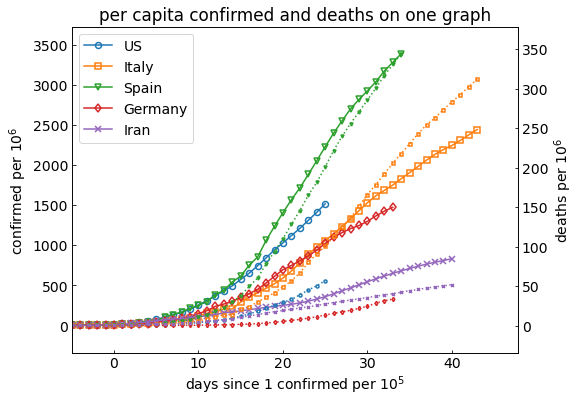

In [13]:
# confirmed per-capita cases and deaths on one graph
N+=1; figure(N, figsize=(fw,fh))
clf()
ax1 = subplot(111)
ax2 = ax1.twinx()
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    ax1.plot(days, ctryd["cnf_pc"], "-"+sbl[i]+clr[i], mfc='none', mew=1.5,
             label=ctryd["name"])
    ax2.plot(days, ctryd["dth_pc"], ":"+sbl[i]+clr[i], mfc='none', mew=1.5, ms=3)
cnf_max = max([corona[country]['cnf_pc'].max() for country in countries])
dth_max = max([corona[country]['dth_pc'].max() for country in countries])
ax1.axis(xmin=-5, ymin=0-cnf_max*0.1, ymax=cnf_max*1.1)
ax2.axis(xmin=-5, ymin=0-dth_max*0.1, ymax=dth_max*1.1)
ax1.set_xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#ax1.set_xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
ax1.set_ylabel("confirmed per $10^%i$" % np.log10(mult))
ax2.set_ylabel("deaths per $10^%i$" % np.log10(mult))
handles, labels = ax1.get_legend_handles_labels()
legend(handles, labels, loc='best')
title("per capita confirmed and deaths on one graph");

This plot compares the trends of confirmed cases vs. deaths. Larger points and solid lines are confirmed, and smaller points and dotted lines are deaths.